<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Hands on Lab: Complete the Machine Learning Prediction lab


Estimated time needed: **60** minutes


### <a href="https://www.linkedin.com/in/gdmacedo/" targert="linkedin"> **Author**: **Macedo, Glener Diniz  -  São Paulo : Brasil**</a>

A Space X anuncia lançamentos de foguetes Falcon 9 em seu site com um custo de 62 milhões de dólares; outros provedores custam mais de 165 milhões de dólares cada, grande parte da economia é porque a Space X pode reutilizar o primeiro estágio. Portanto, se pudermos determinar se o primeiro estágio pousará, podemos determinar o custo de um lançamento. Essas informações podem ser usadas se uma empresa alternativa quiser concorrer contra a Space X para um lançamento de foguete. Neste laboratório, você criará um pipeline de aprendizado de máquina para prever se o primeiro estágio pousará, dados os dados dos laboratórios anteriores.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Vários exemplos de pouso malsucedido são mostrados aqui:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


A maioria dos pousos malsucedidos são planejados. Space X; realiza um pouso controlado nos oceanos.


## Objetivos


Realizar análise exploratória de dados e determinar rótulos de treinamento

* criar uma coluna para a classe
* Padronizar os dados
* Dividir em dados de treinamento e dados de teste

\-Encontrar o melhor hiperparâmetro para SVM, árvores de classificação e regressão logística

* Encontrar o método com melhor desempenho usando dados de teste


## Importar bibliotecas e definir funções auxiliares


In [1]:
import piplite
await piplite.install(['numpy'])
await piplite.install(['pandas'])
await piplite.install(['seaborn'])

Importaremos as seguintes bibliotecas para o laboratório


In [2]:
# Pandas é uma biblioteca de software escrita para a linguagem de programação Python para manipulação e análise de dados.
import pandas as pd

# NumPy é uma biblioteca para a linguagem de programação Python, adicionando suporte para matrizes e arrays grandes  e 
# multidimensionais, juntamente com uma grande coleção de funções matemáticas de alto nível para operar nesses arrays.
import numpy as np

# Matplotlib é uma biblioteca de plotagem para python e pyplot nos dá uma estrutura de plotagem como MatLab.
# Usaremos isso em nossa função plotter para plotar dados.
import matplotlib.pyplot as plt

# Seaborn é uma biblioteca de visualização de dados Python baseada em matplotlib. 
# Ela fornece uma interface de alto nível para desenhar gráficos estatísticos atrativos e informativos
import seaborn as sns

# O pré-processamento nos permite padronizar nossos dados
from sklearn import preprocessing

# Permite-nos dividir nossos dados em dados de treinamento e teste
from sklearn.model_selection import train_test_split

# Permite-nos testar parâmetros de algoritmos de classificação e encontrar o melhor
from sklearn.model_selection import GridSearchCV

# Algoritmo de classificação de regressão logística
from sklearn.linear_model import LogisticRegression

# Algoritmo de classificação da Máquina de Vetores de Suporte
from sklearn.svm import SVC

# Algoritmo de classificação de árvore de decisão
from sklearn.tree import DecisionTreeClassifier

# Algoritmo de classificação de vizinhos mais próximos
from sklearn.neighbors import KNeighborsClassifier

<ipython-input-2-c4e71a0408cf>:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Esta função serve para traçar a matriz de confusão.


In [3]:
def plot_confusion_matrix(y,y_predict):
    "Esta função plota a matriz de confusão"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True para anotar células
    ax.set_xlabel('Rótulos previstos')
    ax.set_ylabel('Rótulos verdadeiros')
    ax.set_title('Matriz de Confusão'); 
    ax.xaxis.set_ticklabels(['Não Aprovado', 'Aprovado']); 
    ax.yaxis.set_ticklabels(['Não Aprovado', 'Aprovado']) 
    plt.show() 

## Carregando o Conjunto de Dados - DataFrame


Carregando os Dados

In [4]:
from js import fetch
import io

URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
resp1 = await fetch(URL1)
text1 = io.BytesIO((await resp1.arrayBuffer()).to_py())
data = pd.read_csv(text1)

In [5]:
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [6]:
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
resp2 = await fetch(URL2)
text2 = io.BytesIO((await resp2.arrayBuffer()).to_py())
X = pd.read_csv(text2)

In [7]:
X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


## Tarefa  1

Crie uma matriz NumPy a partir da coluna <code>Class</code> em <code>data</code>, aplicando o método <code>to_numpy()</code> e, em seguida, atribua-o à variável <code>Y</code>. Certifique-se de que a saída seja uma série Pandas (apenas um colchete  df\['name of  column']).

In [8]:
Y = data['Class'].to_numpy()

## TASK  2


Padronize os dados em <code>X</code> e reatribua-os à variável <code>X</code> usando a transformação fornecida abaixo.

In [9]:
# Os alunos entendem isso
transform = preprocessing.StandardScaler()
X = transform.fit(X).transform(X)

Dividimos os dados em dados de treinamento e teste usando a função <code>train_test_split</code>.  Os dados de treinamento são divididos em dados de validação, um segundo conjunto usado para dados de treinamento; então os modelos são treinados e os hiperparâmetros são selecionados usando a função <code>GridSearchCV</code>.

## TASK  3


Use a função train_test_split para dividir os dados X e Y em dados de treinamento e teste. Defina o parâmetro test_size como 0,2 e random_state como 2. Os dados de treinamento e teste devem ser atribuídos aos seguintes rótulos.


<code>X_train, X_test, Y_train, Y_test</code>


In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

Podemos ver que temos apenas 18 amostras de teste.


In [11]:
Y_test.shape

(18,)

## TASK  4


Crie um objeto de regressão logística e, em seguida, crie um objeto GridSearchCV <code>logreg_cv</code> com cv = 10. Ajuste o objeto para encontrar os melhores parâmetros do dicionário <code>parâmetros</code>.

In [12]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [13]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()
logreg_cv = GridSearchCV(estimator=lr, cv=10, param_grid=parameters).fit(X_train, Y_train)

Nós produzimos o objeto <code>GridSearchCV</code> para regressão logística. Nós exibimos os melhores parâmetros usando o atributo de dados <code>best_params\_</code> e a precisão nos dados de validação usando o atributo de dados <code>best_score\_</code>.

In [14]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713


## TASK  5


Calcule a precisão dos dados de teste usando o método <code>score</code>:

In [15]:
logreg_score = logreg_cv.score(X_test, Y_test)
print("score :", logreg_score)

score : 0.8333333333333334


Vejamos a matriz de confusão:

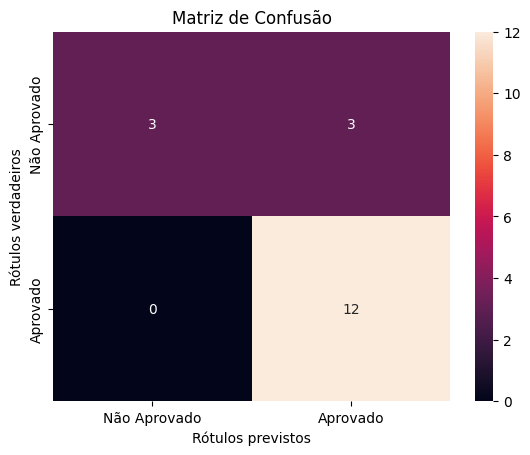

In [18]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Examinando a matriz de confusão, vemos que a regressão logística pode distinguir entre as diferentes classes. Vemos que o problema são os falsos positivos. 

Visão geral:

Verdadeiro Positivo - 12 (O rótulo Verdadeiro é aterrado, o rótulo Previsto também é aterrado)

Falso Postivo - 3 (o rótulo verdadeiro não foi obtido, o rótulo previsto foi obtido)


## TASK  6


Crie um objeto de máquina de vetores de suporte e, em seguida, crie um objeto <code>GridSearchCV</code> <code>svm_cv</code> com cv = 10. Ajuste o objeto para encontrar os melhores parâmetros no dicionário <code>parameters</code>.

In [19]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()
svm_cv = GridSearchCV(estimator=svm, cv=10, param_grid=parameters).fit(X_train, Y_train)

In [20]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856


In [21]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856


## TASK  7


Calcule a precisão dos dados de teste usando o método <code>score</code>:

In [22]:
svm_cv_score = svm_cv.score(X_test, Y_test)
print("score :",svm_cv_score)

score : 0.8333333333333334


Podemos traçar a matriz de confusão

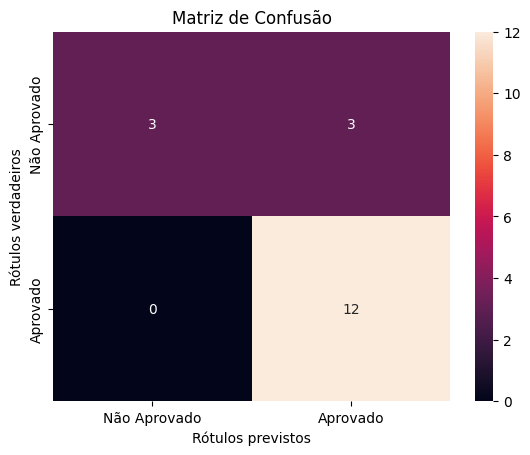

In [23]:
svm_yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,svm_yhat)

## TASK  8


Crie um objeto classificador de árvore de decisão e, em seguida, crie um objeto <code>GridSearchCV</code> <code>tree_cv</code> com cv = 10. Ajuste o objeto para encontrar os melhores parâmetros do dicionário <code>parameters</code>.

In [24]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(estimator=tree, cv=10, param_grid=parameters).fit(X_train, Y_train)

/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
3240 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3240 fits failed with the following error:
Traceback (most recent call last):
  File "/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_p

In [25]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'random'}
accuracy : 0.8767857142857143


## TASK  9


Calcule a precisão de tree_cv nos dados de teste usando o método <code>score</code>:

In [26]:
tree_cv_score = svm_cv.score(X_test, Y_test)
print("score :",tree_cv_score)

score : 0.8333333333333334


Podemos traçar a matriz de confusão

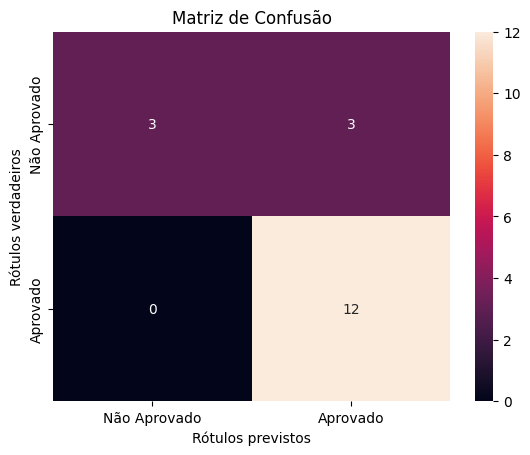

In [27]:
tree_yhat = svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,tree_yhat)

## TASK  10


Crie um objeto k vizinhos mais próximos e, em seguida, crie um objeto <code>GridSearchCV</code> <code>knn_cv</code> com cv = 10. Ajuste o objeto para encontrar os melhores parâmetros do dicionário <code>parâmetros</code>.

In [28]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()
knn_cv = GridSearchCV(estimator=KNN, cv=10, param_grid=parameters).fit(X_train, Y_train)

In [29]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8482142857142858


## TASK  11


Calcule a precisão de knn_cv nos dados de teste usando o método <code>score</code>:

In [30]:
knn_cv_score = knn_cv.score(X_test, Y_test)
print("score :",knn_cv_score)

score : 0.8333333333333334


Podemos traçar a matriz de confusão

In [ ]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  12


Descubra o método que tem melhor desempenho:

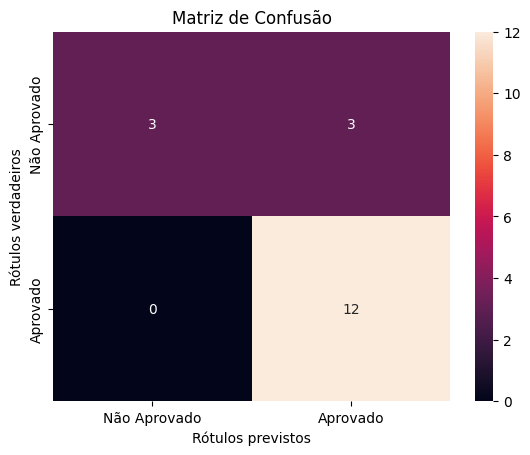

In [31]:
knn_yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,knn_yhat)

## Authors


[Pratiksha Verma](https://www.linkedin.com/in/pratiksha-verma-6487561b1/)


<!--## Change Log--!>


<!--| Date (YYYY-MM-DD) | Version | Changed By      | Change Description      |
| ----------------- | ------- | -------------   | ----------------------- |
| 2022-11-09        | 1.0     | Pratiksha Verma | Converted initial version to Jupyterlite|--!>


### <h3 align="center"> IBM Corporation 2022. All rights reserved. <h3/>
